In [2]:
# a clean version of the data analysis code


import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np 
import json
import os
import rosbag
from sensor_msgs.msg import JointState
import scipy
from scipy.stats import f_oneway

In [3]:
# utils for reading bag files 

def read_bag(bagdir):
    bag = rosbag.Bag(bagdir,'r')
    messages = []
    for _,msg,_ in bag.read_messages(topics=['/my_gen3_lite/joint_states']):
        temp = JointState()
        temp.header = msg.header
        temp.position = msg.position
        temp.velocity = msg.velocity
        temp.name = msg.name
        temp.effort = msg.effort
        messages.append(temp)
    # print("messages length: ",len(messages))
    return messages

def get_all_bag_file_dict(file_path:str=None):
    if file_path is not None:
        file_dir = file_path
    else:
    # use default bag file location
        bag_file_list = []
        bag_file_dict = dict()
        file_dir = os.path.dirname(
                os.path.dirname(
                    os.path.abspath('')
        ))
        file_dir = os.path.join(file_dir,"scripts/bags/")
        print(file_dir)
    # look through directory to find all bag files
    for root, dirs, files in os.walk(file_dir):
        for file in files:
            if file.endswith(".bag"):
                # print(file.split('/'))
                bag_file_dict[root.split('/')[-1]] = os.path.join(root,file)
                bag_file_list.append(os.path.join(root,file))
    return bag_file_dict

def whole_bag_to_messages(bag_file_dict):
    message_dict = dict()
    for user_id, file_name in bag_file_dict.items():
        messages = read_bag(file_name)
        message_dict[user_id] = messages
    return message_dict

# find all json files in a path
def find_json_files(path):
    import os
    json_files = []
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.endswith('.json'):
                json_files.append(os.path.join(root, file))
    return json_files

# load json file from a list of json files, store them in a dictionary, key is the file name without .json
def load_json_files(json_files):
    data = {}
    for file in json_files:
        with open(file, 'r') as f:
            data[os.path.basename(file).split('.')[0]] = json.load(f)
    return data

In [4]:
# utils for forward kinematics

# DF parameters to transformation matrix
def transf_dh(a, alpha, d, theta):
    # input degrees, output radians
    alpha = np.deg2rad(alpha)
    theta = np.deg2rad(theta)
    return np.array([
        [np.cos(theta), -np.sin(theta)*np.cos(alpha), np.sin(theta)*np.sin(alpha), a*np.cos(theta)],
        [np.sin(theta), np.cos(theta)*np.cos(alpha), -np.cos(theta)*np.sin(alpha), a*np.sin(theta)],
        [0, np.sin(alpha), np.cos(alpha), d],
        [0, 0, 0, 1]
    ])

# forward kinematics for Kinova Gen3 Lite
def forward_kinematics(q):
    # q is a nx6
    end_effector_pose = np.zeros((len(q), 6))
    for i in range(len(q)):
        # q radian to degree
        q[i] = np.rad2deg(q[i])
        T56=transf_dh(0,0,0.105+0.130,q[i,5]+90)
        T45=transf_dh(0,90,0.0285*2,q[i,4]+180)
        T34=transf_dh(0,90,0.140+0.105,q[i,3]+90)
        T23=transf_dh(0,90,0.020,q[i,2]+90)
        T12=transf_dh(0.280,180,0.030,q[i,1]+90)
        T01=transf_dh(0,90,0.1283+0.115,q[i,0])
        T06 = T01.dot(T12).dot(T23).dot(T34).dot(T45).dot(T56)
        # get position and orientation
        end_effector_pose[i,0:3] = T06[0:3,3]
        # get row pitch yaw
        scipy.spatial.transform.Rotation.from_matrix(T06[0:3,0:3]).as_euler('zyx')
        end_effector_pose[i,3:6] = scipy.spatial.transform.Rotation.from_matrix(T06[0:3,0:3]).as_euler('zyx')
    return end_effector_pose

In [5]:
# extract necessary information from messages

# get all eef positions from joint pose in a list of messages
def get_all_eef_positions(message_list):
    all_eef_positions = dict()
    for user_id, user_message in message_list.items():
        # print(type(user_message))
        joint_state = np.zeros([len(user_message), 6])
        for i in range(len(user_message)):
            # print(user_message[i])
            # print(user_message[i].position[:6].shape)
            joint_state[i] = np.array(user_message[i].position[:6])
        all_eef_positions[str(user_id)] = forward_kinematics(joint_state)
    return all_eef_positions

# get all task changes from annotation data
def get_all_task_phase_change(annotation_data):
    # read every list of dictionary in the json file, store step if annotation key is  "task phase change"
    all_task_phase_change = dict()
    for user_id, annotation_data_single in annotation_data.items():
        task_phase_change = []
        for annotation in annotation_data_single:
            if annotation['annotation'] == "task phase change":
                task_phase_change.append(annotation["step"])
            # if the step is <0 , make it 0
            task_phase_change = [0 if x < 0 else x for x in task_phase_change]
            # sort the list
            task_phase_change.sort()
        # print(len(task_phase_change))
        if len(task_phase_change)<8 or len(task_phase_change)>8:
            print(user_id)
        all_task_phase_change[user_id] = task_phase_change
    return all_task_phase_change

# get all test controller actions from annotation data
def get_all_test_controller_actions(annotation_data):
    # read every list of dictionary in the json file, store step if annotation key is  "task phase change"
    all_test_controller_actions = dict()
    for user_id, annotation_data_single in annotation_data.items():
        test_controller_actions = []
        for annotation in annotation_data_single:
            if annotation['annotation'] == "test controller":
                test_controller_actions.append([annotation["action_step_start"], annotation["action_step_end"]])
        all_test_controller_actions[user_id] = test_controller_actions
    return all_test_controller_actions

# get all false actions from annotation data
def get_all_false_actions(annotation_data):
    # read every list of dictionary in the json file, store step if annotation key is  "task phase change"
    all_false_actions = dict()
    for user_id, annotation_data_single in annotation_data.items():
        false_actions = []
        for annotation in annotation_data_single:
            if annotation['annotation'] == "false control":
                false_actions.append([annotation["action_step_start"], annotation["action_step_end"]])
        all_false_actions[user_id] = false_actions
    return all_false_actions

# get all alignment actions from annotation data
def get_all_alignment_actions(annotation_data):
    # read every list of dictionary in the json file, store step if annotation key is  "task phase change"
    all_alignment_actions = dict()
    for user_id, annotation_data_single in annotation_data.items():
        alignment_actions = []
        for annotation in annotation_data_single:
            if annotation['annotation'] == "alignment":
                alignment_actions.append([annotation["action_step_start"], annotation["action_step_end"]])
        all_alignment_actions[user_id] = alignment_actions
    return all_alignment_actions

# get all pauses from eef positions
def get_all_pauses(eef_poses_dict:dict):
    pauses_list_all = dict()
    threshold = 0.003
    for user_id, eef_poses_list in eef_poses_dict.items():
        # get element differences
        eef_diff = np.abs(np.diff(eef_poses_list.sum(axis=-1)))
        # get all differences lower than threshold:
        exceed_threshold = eef_diff > threshold
        change_points = np.where(np.diff(exceed_threshold))[0] + 1
        change_points = np.concatenate(([0],change_points,[len(eef_poses_list)-1]))

        subsequences = []
        for i in range(len(change_points) - 1):
            start = change_points[i]
            end = change_points[i+1]

            if np.all(eef_diff[start:end]<= threshold) and end >= start+5:
                subsequences.append([start,end])
        subsequences = [[start + 1, end if end == len(eef_poses_list)-1 else end+1] for start,end in subsequences]
        pauses_list_all[user_id] = subsequences
    return pauses_list_all

# merge all actions
def merge_actions(test_controller_actions:dict, false_actions:dict, alignment_actions:dict, pause_actions:dict = None):
    all_actions = dict()
    # if any action is None, create an empty dictionary
    if pause_actions is None:
        pause_actions = dict()
    
    # make sure all user_ids are in all dictionaries
    for user_id in test_controller_actions.keys():
        if user_id not in false_actions.keys():
            false_actions[user_id] = []
        if user_id not in alignment_actions.keys():
            alignment_actions[user_id] = []
        if user_id not in pause_actions.keys():
            pause_actions[user_id] = []

    for user_id in test_controller_actions.keys():
        all_actions[user_id] = test_controller_actions[user_id] + false_actions[user_id] + alignment_actions[user_id] + pause_actions[user_id]
        all_actions[user_id].sort()
    return all_actions

In [6]:
def get_all_gripper_poses(message_dict):
    gripper_poses = dict()
    for user_id, user_message in message_dict.items():
        gripper_pose = np.zeros([len(user_message), 1])
        for i in range(len(user_message)):
            gripper_pose[i] = np.array(user_message[i].position[6])
        gripper_poses[user_id] = gripper_pose
    return gripper_poses

In [7]:
# read annotations
json_path = os.path.dirname(
        os.path.abspath('')
)

json_path = os.path.join(json_path, 'annotations')
print(json_path)
annotation_files = find_json_files(json_path)
print(len(annotation_files))
annotation_data = load_json_files(annotation_files)

# get all bag files and messages
bag_file_dict = get_all_bag_file_dict()
message_dict = whole_bag_to_messages(bag_file_dict)

# get all eef positions
eef_poses_dict = get_all_eef_positions(message_dict)

/home/frank/human-error/src/replayer/scripts/annotations
40
/home/frank/human-error/src/replayer/scripts/bags/


In [8]:
def calculate_num_button_pressed(eef_poses_dict, 
                                 gripper_poses_dict,):
    num_button_pressed = dict()
    # buttons are pressed when
    # move in the x-y plane
    # move along z axis
    # roll
    # pitch
    # yaw
    # close/open gripper

    eef_threshold = 0.005
    gripper_threshold = 0.002

    num_button_pressed = dict(
        xy = 0,
        z = 0,
        roll = 0,
        pitch = 0,
        yaw = 0,
        gripper = 0
    )

    num_button_pressed_same_time = [0,0,0,0,0,0, 0]


    for user_id in eef_poses_dict.keys():
        print(user_id)
        eef_poses = eef_poses_dict[user_id]
        gripper_poses = gripper_poses_dict[user_id]
        print(eef_poses.shape)
        print(gripper_poses.shape)

        # calculate eef differences
        eef_diff = np.abs(np.diff(eef_poses, axis=0))
        # calculate gripper differences
        gripper_diff = np.abs(np.diff(gripper_poses, axis=0))

        # get all differences lower than threshold:
        exceed_threshold = eef_diff > eef_threshold
        exceed_threshold_gripper = gripper_diff > gripper_threshold

        # join the two arrays
        exceed_threshold = np.concatenate([exceed_threshold, exceed_threshold_gripper], axis=1)
        exceed_threshold_xy = np.logical_or(exceed_threshold[:,0], exceed_threshold[:,1])
        exceed_threshold_xy = exceed_threshold_xy.reshape(-1,1)

        exceed_threshold_without_xy = exceed_threshold[:,2:]

        num_actions_without_xy = np.sum(exceed_threshold_without_xy, axis=1)
        print(num_actions_without_xy.shape)
        num_actions_xy = np.sum(exceed_threshold_xy, axis=1)

        # print(num_actions_without_xy)
        # print(num_actions_xy)
        num_actions_whole = num_actions_xy + num_actions_without_xy
        print(num_actions_xy + num_actions_without_xy)

        # count the number of actions
        num_button_pressed_same_time += np.bincount(num_actions_whole, minlength=7)
            

        # calculate actions with one
    print(num_button_pressed_same_time)
    return num_button_pressed_same_time


gripper_poses = get_all_gripper_poses(message_dict)
num_button_pressed_same_time = calculate_num_button_pressed(eef_poses_dict, gripper_poses)

user_8
(260, 6)
(260, 1)
(259,)
[1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 0 1 1 1 0 1 1 0 1 1 1 0 0 0 1 1 1 0 0 0 1
 1 0 0 0 0 1 1 0 0 0 1 1 1 0 0 1 1 0 0 3 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 2 2 0 0 0 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 1 1 1 0 1 1 1 1 1 2 2 1 0 0 1 1 1 1 1 1 1 1 2 2 1 1 1 1 0 0 0 1 1
 1 1 0 0 0 0 0 0 1 1 0 0 0 0 1 1 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 3
 3 3 0 0 0 0 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 1 1 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
user_3
(262, 6)
(262, 1)
(261,)
[2 2 2 3 2 1 1 1 1 1 1 1 1 1 1 2 2 2 2 3 1 3 1 0 0 1 1 1 0 2 2 3 3 1 1 1 2
 2 3 1 1 2 2 2 2 3 3 1 3 4 3 1 1 1 1 1 2 1 2 2 1 1 2 2 1 1 0 2 1 2 1 1 1 1
 1 1 1 1 1 1 1 1 2 2 0 1 0 0 0 1 1 1 1 1 1 4 3 4 4 3 4 4 4 3 2 2 2 2 2 2 2
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 1 1 0 1 1 1 0
 0 1 1 1 1 1 2 1 0 0 0 1 1 1 1 1 2 2 1 1 1 2 1 1 1 1 1 0 0 1 0 1 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

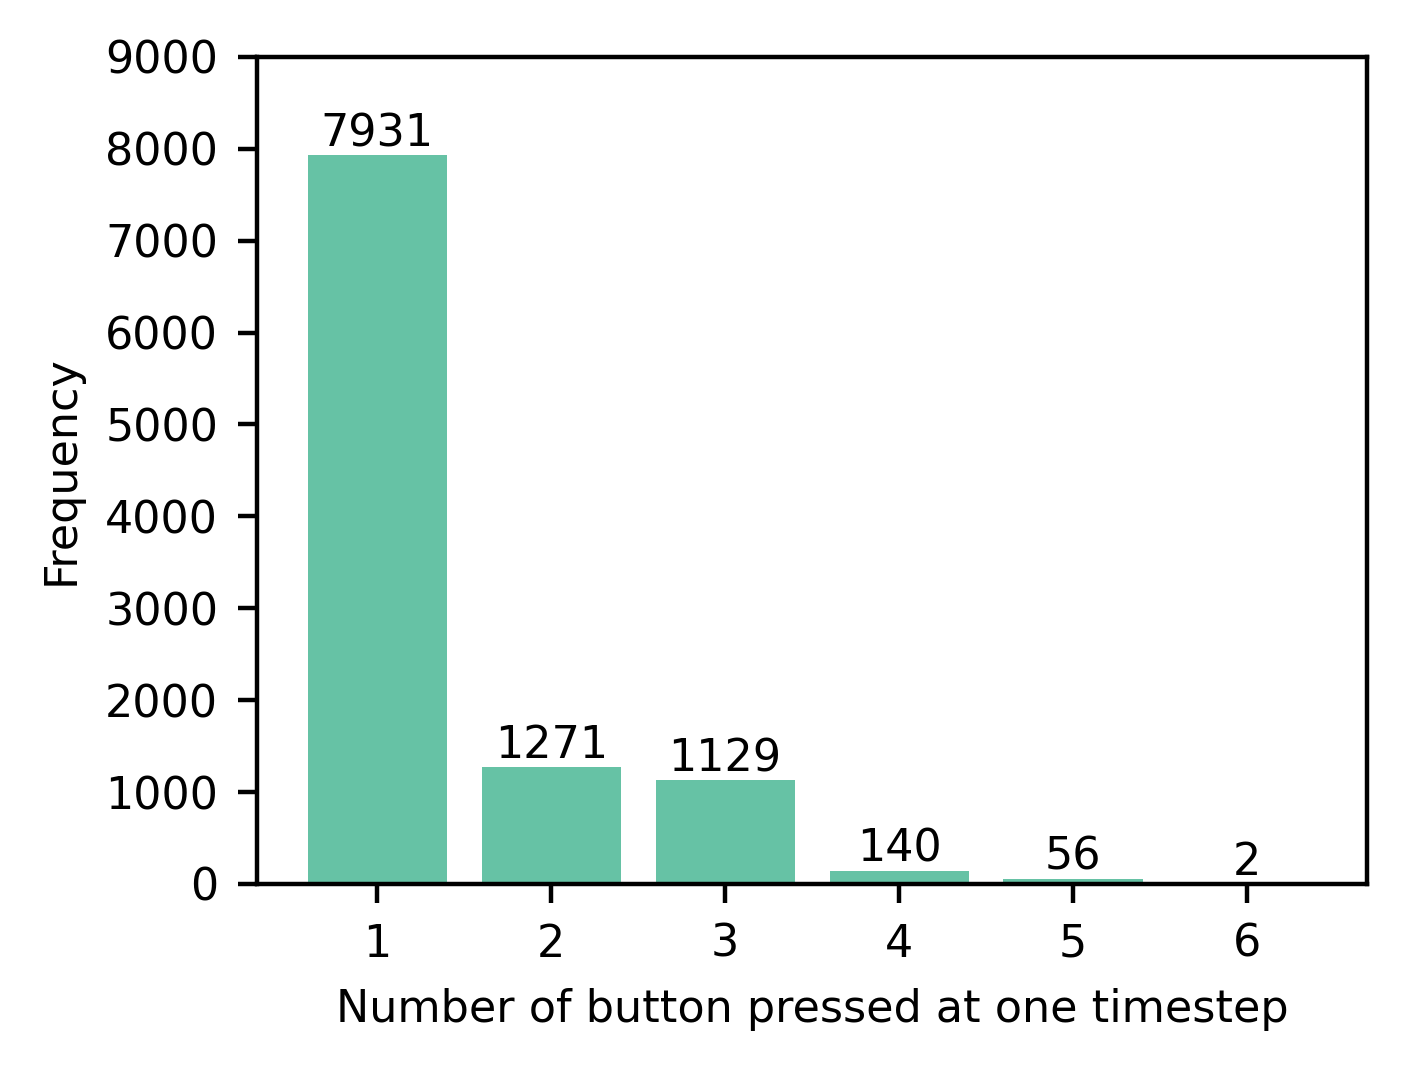

In [17]:
import seaborn as sns

color = sns.color_palette("Set2")
def plot_num_button_pressed(num_button_pressed_same_time):
    # set plot size
    CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
# Set the font size to match IEEE standard
    plt.rcParams.update({'font.size': 8, 'axes.labelsize': 8, 'legend.fontsize': 8, 'xtick.labelsize': 8, 'ytick.labelsize': 8, 
                         'axes.prop_cycle': plt.cycler(color = CB_color_cycle)})

    # Width and height for a double-column figure in IEEE format
    fig_width = 7.16 /2  # width in inches
    fig_height = 3*fig_width / 4   # width in inches
    # fig_height = (fig_width / 36) * 8 # height in inches to maintain 9:6 ratio for each subplot
    # plt.figure(figsize=(fig_width, fig_height))
    plt.figure(figsize=(fig_width, fig_height), dpi=400)
    plt.bar(range(6), num_button_pressed_same_time[1:], color=color[0])
    plt.xticks(range(6), [ '1', '2', '3', '4', '5', '6'])
    # add percentage number on top of each bar
    for i, v in enumerate(num_button_pressed_same_time[1:]):
        plt.text(i, v + 100, str(v) ,ha='center')
    # plt.yticks(fontsize=15)
    # set y limit to 0-9000
    plt.ylim(0, 9000)
    plt.xlabel('Number of button pressed at one timestep', )
    plt.ylabel('Frequency', )
    # plt.title('Number of buttons pushed during each recording time step')
    plt.show()

plot_num_button_pressed(num_button_pressed_same_time)